In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import matplotlib.pyplot as plt
from torchvision import transforms
from torchsummary import summary
import numpy as np
import cv2
import os
import math
from tqdm import tqdm
import pickle

In [18]:
class CompCarDataset(td.dataset.Dataset):
    def __init__(self, train):
        postfix1 = "train" if train else "test"

        mean = [0.4695975, 0.47956536, 0.49133955] # Caclulated using the training set
        std = [0.07418917, 0.0721986, 0.07223192] # Calculated using the training set


        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Pad((0, 121)),
            transforms.Resize((224, 224))
        ])

        self.path_image = "comp-cars/" + postfix1 + "/images"
        self.path_speed = "comp-cars/" + postfix1 + "/speed"
        self.path_type = "comp-cars/" + postfix1 + "/type"

        self.pre_images = np.array(os.listdir(os.path.join(self.path_image)))
        self.pre_labels_speed = np.array(os.listdir(os.path.join(self.path_speed)))
        self.pre_labels_type = np.array(os.listdir(os.path.join(self.path_type)))
        self.pre_images.sort()
        self.pre_labels_speed.sort()
        self.pre_labels_type.sort()

        length = self.pre_images.size
        random = np.random.random_integers(0, length-1, size=(111,))
        self.images = self.pre_images[random]
        self.labels_speed = self.pre_labels_speed[random]
        self.labels_type = self.pre_labels_type[random]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        imagefile = os.path.join(self.path_image, self.images[idx])
        speedfile = open(os.path.join(self.path_speed, self.labels_speed[idx]), "r")
        typefile = open(os.path.join(self.path_type, self.labels_type[idx]), "r")
        img = self.transform(cv2.imread(imagefile))
        spd = torch.tensor(float(speedfile.read()))
        typ = int(typefile.read())
        lbl = torch.zeros(24)
        lbl[typ - 1] = 1
        lbl[12 + math.floor((spd - 100)/(20))] = 1
        return img, lbl, spd


In [3]:
class BasicBlockResNet(nn.Module):
    def __init__(self, channels_in, channels_out, size_change):
        super().__init__()

        self.strides = (2, 2) if size_change else (1, 1)

        self.size_change = size_change

        self.activation = nn.ReLU(inplace=False)

        self.layers = nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=(3, 3), stride=self.strides, padding=(1, 1)),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(inplace=False),
            nn.Conv2d(channels_out, channels_out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(channels_out)
        )

        self.resizing = nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=(1, 1), stride=self.strides),
            nn.BatchNorm2d(channels_out)
        )

    def forward(self, x):
        residual = x
        x = self.layers(x)
        if self.size_change:
            residual = self.resizing(residual)
        x += residual
        x = self.activation(x)
        return x

In [4]:
#Final Tensor needs to be of Length 24 (12 car types, and 12 speed zones)
class ResNet18(nn.Module):
    def __init__(self, channels_in, sizes=[64, 128, 256, 512], num_classes=24):
        super().__init__()

        self.first_layer = nn.Sequential(
            nn.Conv2d(channels_in, sizes[0], kernel_size=(7, 7), stride=(2, 2), padding=3),
            nn.BatchNorm2d(sizes[0]),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1)
        )

        self.middle_layers = nn.Sequential(
            BasicBlockResNet(sizes[0], sizes[0], False),
            BasicBlockResNet(sizes[0], sizes[0], False),
            BasicBlockResNet(sizes[0], sizes[1], True),
            BasicBlockResNet(sizes[1], sizes[1], False),
            BasicBlockResNet(sizes[1], sizes[2], True),
            BasicBlockResNet(sizes[2], sizes[2], False),
            BasicBlockResNet(sizes[2], sizes[3], True),
            BasicBlockResNet(sizes[3], sizes[3], False)
        )

        self.final_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(sizes[3], num_classes)
        )

    def forward(self, x):        
        x = self.first_layer(x)
        x = self.middle_layers(x)
        x = self.final_layer(x)
        return x

In [5]:
class SpeedClassifier(nn.Module):
    def __init__(self, channels_in):
        super().__init__()
        self.n_classes = channels_in
        self.layers = nn.Sequential(
            nn.Linear(self.n_classes, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
def deepLoss(prediction, label, loss_tuning=torch.tensor(1), 
rates=torch.Tensor([0.0431, 0.2164, 0.4099, 0.1916, 0.0091, 0.0314, 0.0164, 0.0053, 0.0137,
        0.0495, 0.0053, 0.0083, 0.0000, 0.0113, 0.0411, 0.2049, 0.2914, 0.2202,
        0.1125, 0.0954, 0.0110, 0.0043, 0.0041, 0.0039])):
        output_shape = prediction.shape
        loss = 0
        for i in range(output_shape[0]):
            yil = label[i, :]
            wl = torch.where((yil == 1), torch.exp((1 - rates)/(torch.pow(loss_tuning, 2))), torch.exp((rates)/(torch.pow(loss_tuning, 2))))

            pil = 1 / (1 + torch.exp(-prediction[i, :]))
            iter_loss = wl * ((yil * torch.log(pil)) + ((1 - yil)* torch.log(1 - pil)))
            loss += torch.sum(iter_loss)  
        
        return ((-loss)/(output_shape[0]))

In [7]:
def get_dataloader(dataset, batch):
    dataloader = td.DataLoader(dataset, batch_size=batch,shuffle=True)
    return dataloader

In [8]:
def make_prediction(pred):
    return torch.argmax(pred, dim=1)

In [19]:
def runNetwork(batch, train, num_epochs, net, speed_net):

    speed_criterion = nn.MSELoss()
    if train:
        net.train()
        speed_net.train()
    else:
        net.eval()
        speed_net.eval()

    hist_mar_loss = []
    hist_loss = []
    mean_errors = []
    accuracy_rates = []
    optimizer = torch.optim.Adam(net.parameters(), lr=0.015)
    speed_optimizer = torch.optim.Adam(speed_net.parameters(), lr=1.5)
    for i in range(num_epochs):
        dataset = CompCarDataset(train)
        loader = get_dataloader(dataset, batch)
        epoch_speed_mean_error = 0
        epoch_type_correct = 0
        epoch_iterations = 0
        #for idx, data in enumerate(loader):
        for img, lbl, spd in tqdm(loader):        
            #img, lbl, spd = data
            prediction = net.forward(img)
            loss = deepLoss(prediction, lbl)

            split_prediction = torch.split(prediction, 12, dim=1)
            lbl_convert = torch.split(lbl, 12, dim=1)
            type_truth = make_prediction(lbl_convert[0])
            type_pred = make_prediction(split_prediction[0])

            speed_input = split_prediction[1].detach()
            speed_pred = torch.flatten(speed_net.forward(speed_input))
            speed_loss = speed_criterion(speed_pred, spd)

            hist_mar_loss.append(loss.item())
            hist_loss.append(speed_loss.item())

            if train:
                speed_optimizer.zero_grad()
                optimizer.zero_grad()

                speed_loss.backward(retain_graph=True)
                loss.backward()

                speed_optimizer.step()
                optimizer.step()


            eq = torch.eq(type_truth, type_pred).sum().item()
            epoch_type_correct += eq
            
            speed_mean_errors = (torch.sum(torch.abs(speed_pred - spd)).item())/(batch)
            epoch_speed_mean_error += speed_mean_errors
            epoch_iterations += 1
        
        mean_errors.append((epoch_speed_mean_error/epoch_iterations))
        accuracy_rates.append((epoch_type_correct/(epoch_iterations * batch)))

        print('Epoch {}: Mean Error (Speed): {:.4f} Accuracy (Type): {:.4f}'.format(i, (epoch_speed_mean_error/epoch_iterations), (epoch_type_correct/(epoch_iterations * batch))))

    return hist_mar_loss, hist_loss, mean_errors, accuracy_rates
            

In [10]:
network = ResNet18(3)
speed_network = SpeedClassifier(12)
hist_mar_loss, hist_loss, mean_errors, accuracy_rates = runNetwork(50, True, 100, network, speed_network)

with open('hist_loss.txt', 'wb') as hl_file:
    pickle.dump(hist_loss, hl_file)
    
with open('hist_mar_loss.txt', 'wb') as hml_file:
    pickle.dump(hist_mar_loss, hml_file)

with open('mean_errors.txt', 'wb') as me_file:
    pickle.dump(mean_errors, me_file)

with open('accuracy_rates.txt', 'wb') as ar_file:
    pickle.dump(accuracy_rates, ar_file)

torch.save(network.state_dict(), 'net.txt')
torch.save(speed_network.state_dict(), 'speed_net.txt')

100%|██████████| 10/10 [01:31<00:00,  9.12s/it]Epoch 99: Mean Error (Speed): 25.1102 Accuracy (Type): 0.4120



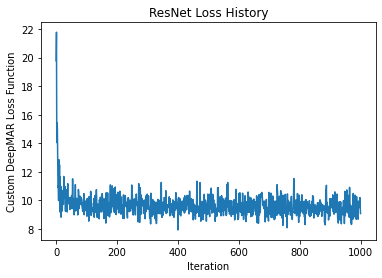

In [12]:
plt.plot(hist_mar_loss)
plt.xlabel('Iteration')
plt.ylabel('Custom DeepMAR Loss Function')
plt.title('ResNet Loss History')
plt.show()


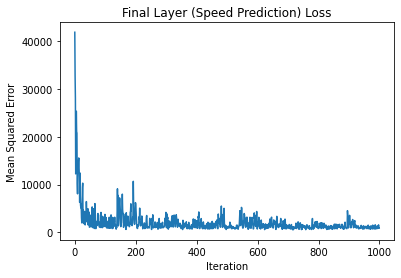

In [13]:
plt.plot(hist_loss)
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Final Layer (Speed Prediction) Loss')
plt.show()

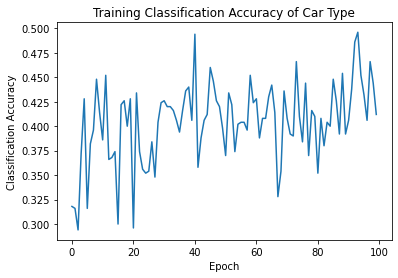

In [14]:
plt.plot(accuracy_rates)
plt.xlabel('Epoch')
plt.ylabel('Classification Accuracy')
plt.title('Training Classification Accuracy of Car Type')
plt.show()

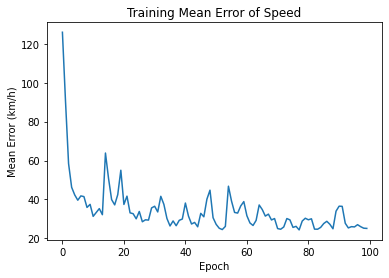

In [15]:
plt.plot(mean_errors)
plt.xlabel('Epoch')
plt.ylabel('Mean Error (km/h)')
plt.title('Training Mean Error of Speed')
plt.show()

In [24]:
thist_mar_loss, thist_loss, tmean_errors, taccuracy_rates = runNetwork(111, False, 100, network, speed_network)

100%|██████████| 1/1 [00:16<00:00, 16.95s/it]
Epoch 2: Mean Error (Speed): 24.7185 Accuracy (Type): 0.4234
100%|██████████| 1/1 [00:16<00:00, 16.81s/it]
Epoch 6: Mean Error (Speed): 24.3151 Accuracy (Type): 0.4775
100%|██████████| 1/1 [00:15<00:00, 15.42s/it]
Epoch 7: Mean Error (Speed): 25.2438 Accuracy (Type): 0.4685
100%|██████████| 1/1 [00:11<00:00, 11.97s/it]
Epoch 12: Mean Error (Speed): 24.1080 Accuracy (Type): 0.4324
100%|██████████| 1/1 [00:15<00:00, 15.64s/it]
Epoch 16: Mean Error (Speed): 28.1822 Accuracy (Type): 0.4144
100%|██████████| 1/1 [00:14<00:00, 14.13s/it]
Epoch 20: Mean Error (Speed): 28.4346 Accuracy (Type): 0.3874
100%|██████████| 1/1 [00:19<00:00, 19.46s/it]
Epoch 27: Mean Error (Speed): 23.9103 Accuracy (Type): 0.4505
100%|██████████| 1/1 [00:25<00:00, 25.89s/it]
Epoch 28: Mean Error (Speed): 27.2387 Accuracy (Type): 0.4414
100%|██████████| 1/1 [00:16<00:00, 16.49s/it]
Epoch 31: Mean Error (Speed): 26.2625 Accuracy (Type): 0.4414
100%|██████████| 1/1 [00:14<00:

In [25]:
print(sum(tmean_errors)/len(tmean_errors))

25.59316210497609


In [26]:
print(sum(taccuracy_rates)/len(taccuracy_rates))

0.4149549549549548
